### Data Loading and Subsetting

- Imported necessary libraries.
- Loaded the dataset from a JSON file.
- Checked the number of reviews and created a subset of the data if the number of reviews is greater than or equal to 2000.
- Displayed the first few rows of the subset data.

In [129]:
import pandas as pd
import os

# Load the dataset
url = "https://raw.githubusercontent.com/Timothy965/COMP262_GROUP5/refs/heads/phase2/Dataset/Gift_Cards_Phase2.json"
data = pd.read_json(url, lines=True)

# Check the number of reviews
if len(data) >= 2000:
    df = data.sample(n=2000, random_state=42)
else:
    df = data

# Display the subset data
print(df.head())

        overall vote  verified   reviewTime      reviewerID        asin style  \
83758         3  NaN      True  08 26, 2013  A2ZVB7VWCR7NZC  B00CRQ47WC   NaN   
135602        5  NaN      True  09 14, 2016  A1HGHX5WY3TZI0  B01G44QKQI   NaN   
65221         5  NaN      True  10 17, 2017  A3GKHR97RTKO49  B00AR51Y5I   NaN   
39765         5  NaN      True  01 18, 2013  A274I7QL4K9LJ1  B0062ONLI6   NaN   
2495          5  NaN      True  05 26, 2014  A2BWP68V8GPLZA  B004KNWX6C   NaN   

              reviewerName                                         reviewText  \
83758              Michael  Not much to really say about this other than i...   
135602                John                                                 Ok   
65221                 Jucy                                               Good   
39765   Louis H. Goetz Sr.  The gift card was printed on line and we found...   
2495         Terese Bedard  I very much like the print-at-home Amazon gift...   

                          

In [130]:
# Function to check if the column is hashable
def is_hashable(s):
    return all(isinstance(x, (int, float, str, bool)) for x in s.dropna())

### Data Exploration and Analysis

- Displayed total number of reviews, average rating, and average review length.
- Provided dataframe information.
- Visualized distribution of reviews across products.
- Visualized distribution of reviews per user.
- Analyzed review lengths and identified outliers.
- Checked for duplicate reviews using hashable columns.

Total number of reviews: 2000
Average rating: 4.648
Average review length: 100.51151151151151
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 83758 to 39037
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         2000 non-null   int64 
 1   vote            96 non-null     object
 2   verified        2000 non-null   bool  
 3   reviewTime      2000 non-null   object
 4   reviewerID      2000 non-null   object
 5   asin            2000 non-null   object
 6   style           581 non-null    object
 7   reviewerName    1999 non-null   object
 8   reviewText      1998 non-null   object
 9   summary         2000 non-null   object
 10  unixReviewTime  2000 non-null   int64 
 11  image           7 non-null      object
dtypes: bool(1), int64(2), object(9)
memory usage: 189.5+ KB
Dataframe info
 None


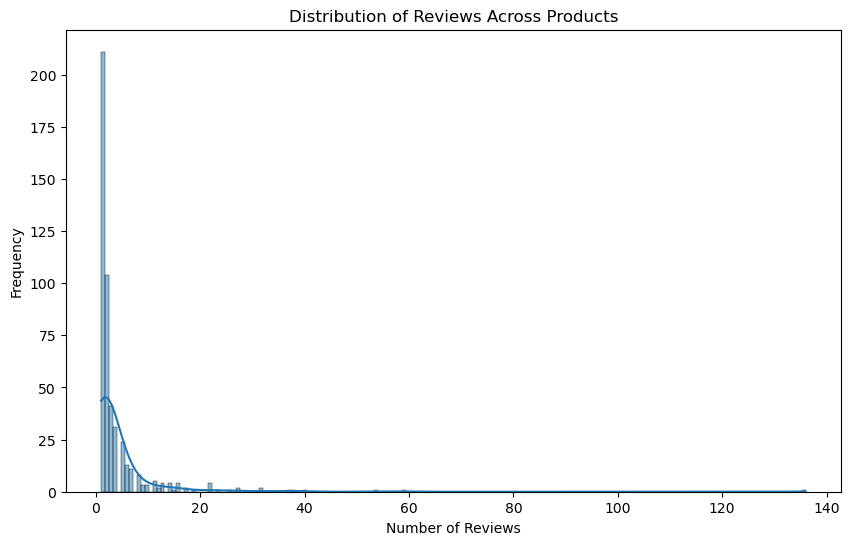

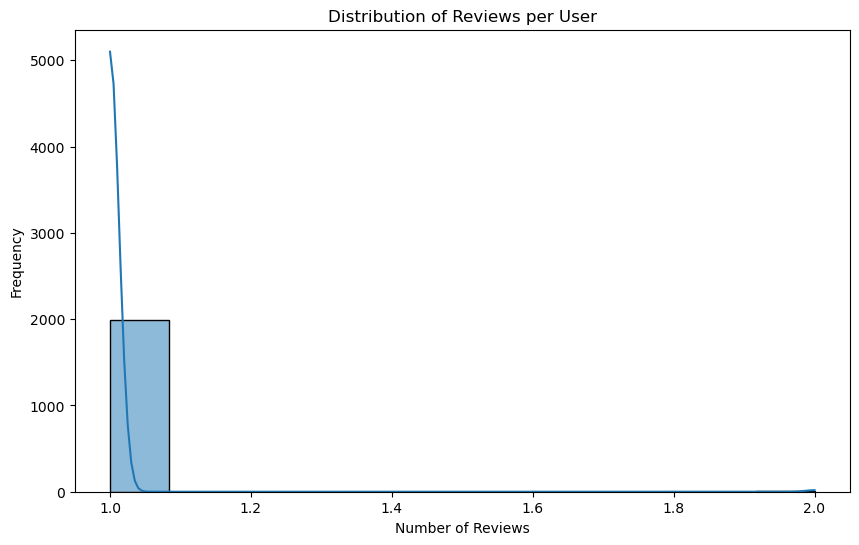

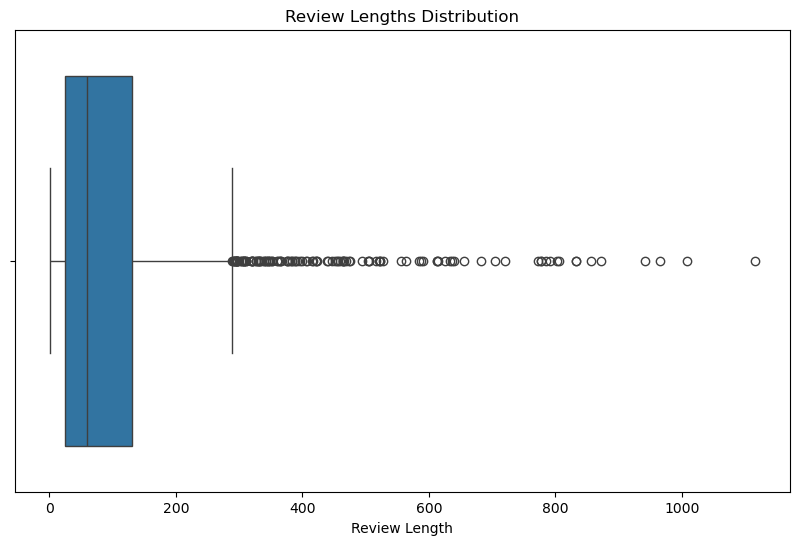

Minimum review length: 1.0
Maximum review length: 1115.0
Median review length: 60.0
Columns used for duplicate checking: ['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime']
Number of duplicate reviews (using hashable columns): 0


In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Dataset data exploration
# a) Counts, averages, infor
print("Total number of reviews:", len(df))
print("Average rating:", df['overall'].mean())
print("Average review length:", df['reviewText'].str.len().mean())
print("Dataframe info\n", df.info())

# b) Distribution of the number of reviews across products
product_review_counts = df['asin'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(product_review_counts, kde=True)
plt.title('Distribution of Reviews Across Products')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# d) Distribution of reviews per user
user_review_counts = df['reviewerID'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, kde=True)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# e) Review lengths and outliers
review_lengths = df['reviewText'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(x=review_lengths)
plt.title('Review Lengths Distribution')
plt.xlabel('Review Length')
plt.show()

# f) Analyze lengths
print("Minimum review length:", review_lengths.min())
print("Maximum review length:", review_lengths.max())
print("Median review length:", review_lengths.median())

# g) Check for duplicates
# We'll check for duplicates using only hashable columns
hashable_columns = [col for col in df.columns if is_hashable(df[col])]
print("Columns used for duplicate checking:", hashable_columns)
duplicate_count = df.duplicated(subset=hashable_columns).sum()
print("Number of duplicate reviews (using hashable columns):", duplicate_count)

### Preprocessing
This script processes review text data to identify and visualize the 20 most frequent words.

Functions:
    preprocess_text(text): Converts text to lowercase, tokenizes it, and removes stopwords and non-alphabetic tokens.

Workflow:
1. Combine all review texts from a DataFrame.
2. Preprocess the combined text to tokenize and clean it.
3. Count the frequency of each word.
4. Identify the 20 most common words.
5. Print the 20 most frequent words.
6. Visualize the word frequencies using a bar chart.


20 Most Frequent Words:
gift: 1356
card: 804
amazon: 395
great: 388
cards: 283
easy: 276
get: 179
love: 174
use: 164
way: 152
perfect: 151
good: 136
loved: 127
like: 124
time: 123
buy: 121
give: 116
one: 115
christmas: 115
birthday: 108


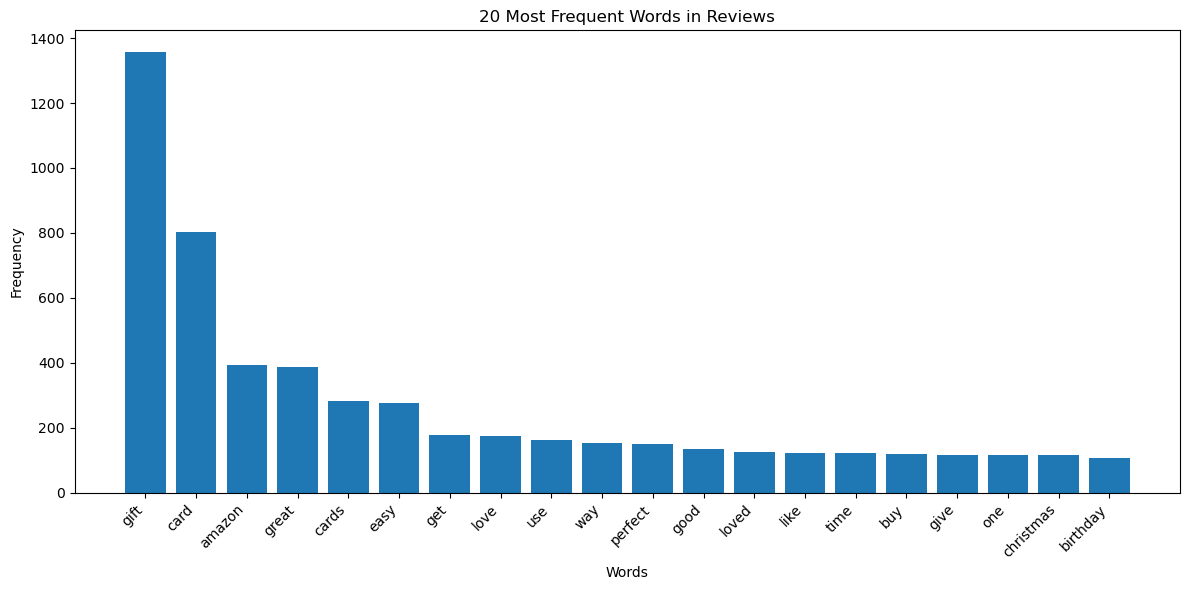

In [132]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Combine all review texts
all_text = ' '.join(df['reviewText'].dropna())

# Preprocess the combined text
words = preprocess_text(all_text)

# Count word frequencies
word_freq = Counter(words)

# Get the 20 most common words
most_common_words = word_freq.most_common(20)

# Print the results
print("20 Most Frequent Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Visualize the results
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.title('20 Most Frequent Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Sentiment Analysis Visualization

- Generates word clouds for positive and negative reviews.
- Analyzes review length vs. sentiment.
- Calculates average review length by sentiment.
- Displays correlation between review length and rating.

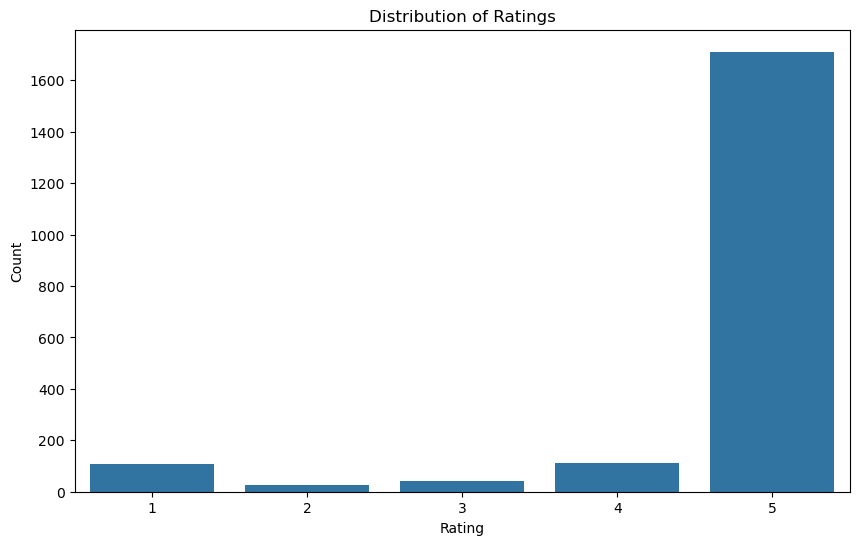

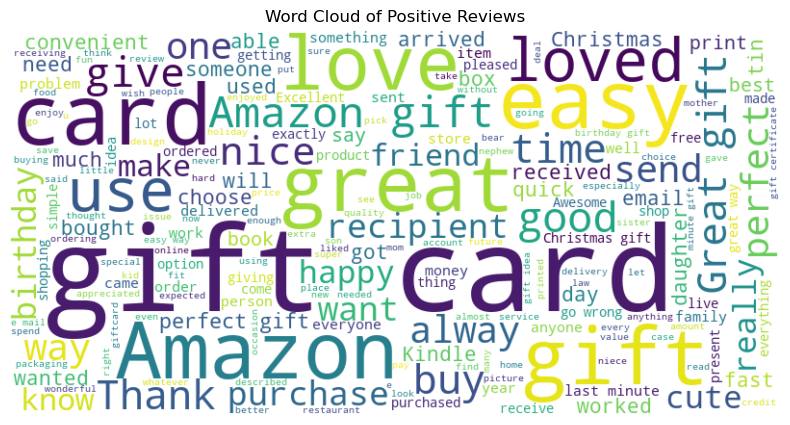

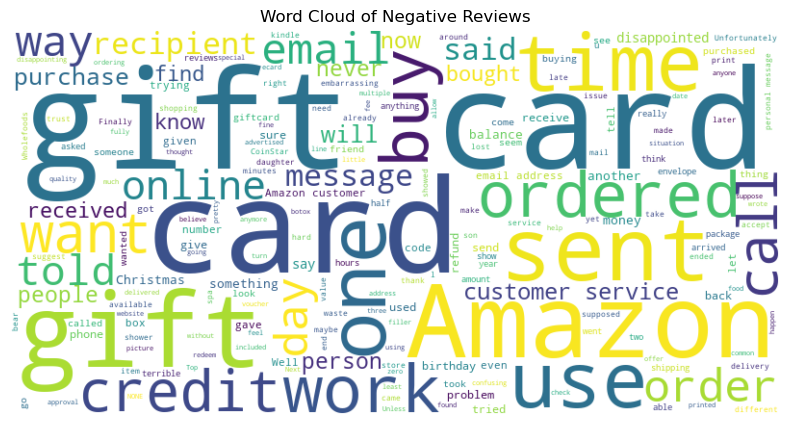

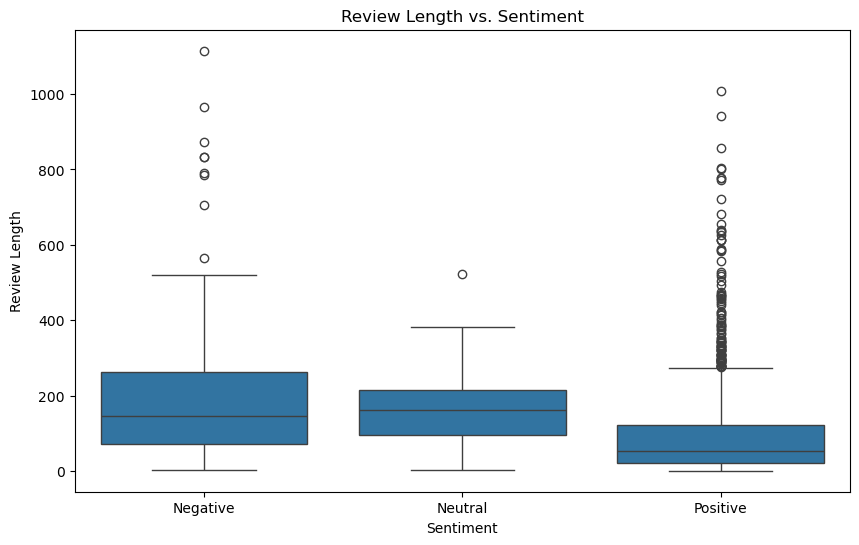


Average review length by sentiment:
sentiment
Negative    210.887218
Neutral     165.093023
Positive     90.930296
Name: review_length, dtype: float64


Correlation between review length and rating: -0.26


In [136]:
from wordcloud import WordCloud
import numpy as np

#  Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()
print()

#  Word clouds for positive and negative reviews
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Positive reviews (rating >= 4)
positive_reviews = ' '.join(df[df['overall'] >= 4]['reviewText'].dropna())
generate_wordcloud(positive_reviews, 'Word Cloud of Positive Reviews')
print()

# Negative reviews (rating <= 2)
negative_reviews = ' '.join(df[df['overall'] <= 2]['reviewText'].dropna())
generate_wordcloud(negative_reviews, 'Word Cloud of Negative Reviews')
print()

# Review length analysis
df['review_length'] = df['reviewText'].str.len()

# Create sentiment categories
df['sentiment'] = pd.cut(df['overall'],
                         bins=[-np.inf, 2, 3, np.inf],
                         labels=['Negative', 'Neutral', 'Positive'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

# Calculate average review length for each sentiment
avg_length = df.groupby('sentiment', observed=False)['review_length'].mean()
print("\nAverage review length by sentiment:")
print(avg_length)
print()

# Correlation between review length and rating
correlation = df['review_length'].corr(df['overall'])
print(f"\nCorrelation between review length and rating: {correlation:.2f}")